# MVP Notebook Daniel

In [3]:
import preprocessing
import wrangle
import model

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


# ignore warnings
import warnings
warnings.simplefilter(action='ignore')

In [144]:
df = preprocessing.get_model_df()

In [145]:
df

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label
0,Bronx,NY,2013,8,822430600,1.028038e+08,24774500.0,NaN,NaN,NaN,NaN,False
1,Trenton,NJ,2009,3,760934400,2.536448e+08,4100000.0,1.0,755874500.0,755874500.0,755874500.0,False
2,New York,NY,2013,7,647062504,9.243750e+07,27400000.0,1.0,9364704.0,9364704.0,9364704.0,False
3,Chicago,IL,2012,45,520309300,1.156243e+07,8300000.0,NaN,NaN,NaN,NaN,False
4,Chicago,IL,2011,43,494045600,1.148943e+07,8677500.0,1.0,5387000.0,5387000.0,5387000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
13598,Albany,GA,2008,1,152400,1.524000e+05,152400.0,NaN,NaN,NaN,NaN,False
13599,Cordele,GA,2008,1,145000,1.450000e+05,145000.0,NaN,NaN,NaN,NaN,False
13600,Covington,KY,2006,1,125000,1.250000e+05,125000.0,NaN,NaN,NaN,NaN,False
13601,Wolcottville,IN,2017,1,114000,1.140000e+05,114000.0,NaN,NaN,NaN,NaN,False


In [3]:
df = preprocessing.add_new_features(df)

In [ ]:
df

In [5]:
def filter_top_cities(df):

    df["city_state"] = df["city"] + "_" + df["state"]

    city_mask = df.groupby("city_state").year.count()

    city_mask = city_mask[city_mask == 15]

    # apply city mask to shrink the df
    def in_city_mask(x):
        return x in city_mask
    df = df[df.city_state.apply(in_city_mask)]

    df = df.sort_values(["city", "state", "year"])
    
    return df

In [5]:
df = filter_top_cities(df)

## <span style='background :yellow' > Adding the labeling </span>

In [6]:
# # Using the Evolution Index as a label:
# # For values that are higher than 100% in evolution index.

# df["ei_label"] = np.where(df.ei > 1, 1, 0)

In [6]:
# using future data to create the labels

def labeling_future_data(df):
    """this function takes in a data frame and returns a boolean column that identifies
    if a city_state_year is a market that should be entered"""
    df["label_quantity_of_mortgages_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["quantity_of_mortgages_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    df["label_total_mortgage_volume_pop_2y"] = (df.sort_values(["year"])
                                  .groupby(["city", "state"])[["total_mortgage_volume_pop"]]
                                  .pct_change(2)
                                  .shift(-2))
    Q3 = df.label_quantity_of_mortgages_pop_2y.quantile(.75)
    Q1 = df.label_quantity_of_mortgages_pop_2y.quantile(.25)
    upper_fence_quantity = Q3 + ((Q3-Q1)*1.5)
    upper_fence_quantity
    Q3 = df.label_total_mortgage_volume_pop_2y.quantile(.75)
    Q1 = df.label_total_mortgage_volume_pop_2y.quantile(.25)
    upper_fence_volume = Q3 + ((Q3-Q1)*1.5)
    upper_fence_volume
    df['should_enter'] = (df.label_total_mortgage_volume_pop_2y > upper_fence_volume) | (df.label_quantity_of_mortgages_pop_2y > upper_fence_quantity)
    return df

In [8]:
df = labeling_future_data(df)

In [9]:
df.should_enter.value_counts()

False    338
True      52
Name: should_enter, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1513 to 156
Data columns (total 23 columns):
city                                  390 non-null object
state                                 390 non-null object
year                                  390 non-null int64
quantity_of_mortgages_pop             390 non-null int64
total_mortgage_volume_pop             390 non-null int64
average_mortgage_volume_pop           390 non-null float64
median_mortgage_amount_pop            390 non-null float64
quantity_of_mortgages_nc              180 non-null float64
total_mortgage_volume_nc              180 non-null float64
average_mortgage_volume_nc            180 non-null float64
median_mortgage_amount_nc             180 non-null float64
label                                 390 non-null bool
city_state_vol_delta_pop              364 non-null float64
city_state_vol_delta_nc               310 non-null float64
city_state_qty_delta_pop              364 non-null float64
city_state_qty_del

In [11]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [10]:
def train_test_data(df):
    train, test = train_test_split(df, train_size=.75, random_state=123, stratify = df["should_enter"])
    return train, test

#__Main Pre-modeling function__#
def prep_data_for_modeling(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 2007]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]
    features_for_modeling += [label_feature]
    data = df_model[features_for_modeling].set_index("observation_id")

    train, test = train_test_data(data)
    train = train.sort_values("observation_id")
    test = test.sort_values("observation_id")

    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]

    return X_train, y_train, X_test, y_test

In [13]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
X_train, y_train, X_test, y_test = prep_data_for_modeling(df, features_for_modeling, label_feature)

In [8]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values(scaler, train, test):
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, test_scaled

# Linear scaler
def min_max_scaler(train, test):
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, test_scaled = return_values(scaler, train , test)
    return scaler, train_scaled, test_scaled

In [15]:
# Scaler is ready - in case we need it

scaler, train_scaled, test_scaled = min_max_scaler(X_train, X_test)

In [16]:
assert(train_scaled.shape[1] == test_scaled.shape[1])

In [17]:
train_scaled.head()

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2008,0.021739,0.010172,0.008122,0.033455
Atlanta_GA_2010,0.217391,0.087637,0.022332,0.056728
Atlanta_GA_2011,0.195652,0.063380,0.025009,0.045856
Atlanta_GA_2012,0.239130,0.085915,0.026302,0.031960
Atlanta_GA_2014,0.217391,0.037806,0.039231,0.053211


In [18]:
train_scaled.isnull().sum()

quantity_of_mortgages_pop     0
city_state_qty_delta_pop      0
ei                            0
median_mortgage_amount_pop    0
dtype: int64

In [19]:
grid, df_result, best_model = model.run_decision_tree(train_scaled, y_train)

{'criterion': 'entropy', 'max_depth': 10, 'score': 0.2333333333333333}


In [20]:
grid, df_result, best_model = model.run_random_forest(train_scaled, y_train)

{'max_depth': 7, 'min_samples_leaf': 2, 'score': 0.10714285714285714}


In [21]:
grid, df_result, best_model = model.run_knn(train_scaled, y_train)

{'n_neighbors': 1, 'weights': 'uniform', 'score': 0.175}


----

# Evaluation

In [123]:
grid, df_result, best_model = model.run_decision_tree(train_scaled, y_train)

{'criterion': 'entropy', 'max_depth': 8, 'score': 0.225}


In [124]:
y_pred = best_model.predict(train_scaled)

In [125]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_train, y_pred), index = labels, columns = labels)

In [126]:
recall_score(y_train, y_pred)

0.7948717948717948

In [127]:
print(matrix)

       False  True 
False    212      2
True       8     31


In [128]:
best_model.score(test_scaled, y_test)

0.788235294117647

In [129]:
y_pred = best_model.predict(test_scaled)

In [130]:
labels = sorted(y_train.unique())
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index = labels, columns = labels)

In [131]:
recall_score(y_test, y_pred)

0.3076923076923077

In [132]:
print(matrix)

       False  True 
False     63      9
True       9      4


In [146]:
best_model.score(train_scaled, y_train)

0.9604743083003953

In [147]:
y_train

observation_id
Atlanta_GA_2008       False
Atlanta_GA_2010        True
Atlanta_GA_2011       False
Atlanta_GA_2012        True
Atlanta_GA_2014       False
                      ...  
Washington_DC_2015    False
Washington_DC_2017    False
Washington_DC_2018    False
Washington_DC_2019    False
Washington_DC_2020    False
Name: should_enter, Length: 253, dtype: bool

----

# Prediction

In [32]:
model_df = preprocessing.get_model_df()

df["city_state"] = df["city"] + "_" + df["state"]

city_mask = df.groupby("city_state").year.count()

city_mask = city_mask[city_mask == 15]

# apply city mask to shrink the df
def in_city_mask(x):
    return x in city_mask
df = df[df.city_state.apply(in_city_mask)]

df = preprocessing.add_new_features(df)

df = df.sort_values(["city", "state", "year"])

In [33]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,...,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state,label_quantity_of_mortgages_pop_2y,label_total_mortgage_volume_pop_2y,should_enter
1513,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,...,NaN,NaN,NaN,985749936,NaN,NaN,Atlanta_GA,NaN,NaN,False
1815,Atlanta,GA,2007,9,29105800,3.233978e+06,2990200.0,2.0,4541700.0,2270850.0,...,-0.505321,0.500000,0.0,952578100,-0.033651,0.907570,Atlanta_GA,NaN,NaN,False
7673,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,...,0.089900,-0.777778,-0.5,432971200,-0.545474,0.509096,Atlanta_GA,0.0,-0.812906,False
773,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,...,-0.242424,3.500000,0.0,1116634600,1.579004,2.877033,Atlanta_GA,4.5,9.213569,True
469,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,...,0.920933,0.222222,1.0,2568950085,1.300618,0.598323,Atlanta_GA,4.5,14.076042,True


In [41]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [42]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
city_state,,,,
Atlanta_GA,2.5,-0.208333,0.854755,14743525.0
Austin_TX,4.0,-0.250000,1.443730,27422850.0
Baltimore_MD,6.5,-0.437500,0.829841,12466625.0
Boston_MA,12.5,-0.068681,1.139998,11158750.0
Chicago_IL,11.0,-0.344322,1.028100,12010100.0
Cincinnati_OH,5.5,0.633333,2.437869,8620350.0
Cleveland_OH,2.0,0.571429,1.131003,9025000.0
Dallas_TX,4.0,-0.166667,1.296162,30065025.0
Detroit_MI,2.0,0.583333,5.962691,19445600.0


In [43]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [44]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [45]:
predictions["label"] = best_model.predict(predictions_scaled)

In [46]:
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label
city_state,,,,,
Atlanta_GA,2.5,-0.208333,0.854755,14743525.0,False
Austin_TX,4.0,-0.250000,1.443730,27422850.0,True
Baltimore_MD,6.5,-0.437500,0.829841,12466625.0,False
Boston_MA,12.5,-0.068681,1.139998,11158750.0,True
Chicago_IL,11.0,-0.344322,1.028100,12010100.0,True
Cincinnati_OH,5.5,0.633333,2.437869,8620350.0,True
Cleveland_OH,2.0,0.571429,1.131003,9025000.0,True
Dallas_TX,4.0,-0.166667,1.296162,30065025.0,True
Detroit_MI,2.0,0.583333,5.962691,19445600.0,True


In [47]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [48]:
predictions = predictions.reset_index()

In [49]:
predictions["city"] = city

predictions["state"] = state

In [50]:
predictions

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.5,-0.208333,0.854755,14743525.0,False,Atlanta,GA
1,Austin_TX,4.0,-0.250000,1.443730,27422850.0,True,Austin,TX
2,Baltimore_MD,6.5,-0.437500,0.829841,12466625.0,False,Baltimore,MD
3,Boston_MA,12.5,-0.068681,1.139998,11158750.0,True,Boston,MA
4,Chicago_IL,11.0,-0.344322,1.028100,12010100.0,True,Chicago,IL
5,Cincinnati_OH,5.5,0.633333,2.437869,8620350.0,True,Cincinnati,OH
6,Cleveland_OH,2.0,0.571429,1.131003,9025000.0,True,Cleveland,OH
7,Dallas_TX,4.0,-0.166667,1.296162,30065025.0,True,Dallas,TX
8,Detroit_MI,2.0,0.583333,5.962691,19445600.0,True,Detroit,MI
9,Houston_TX,5.0,-0.541667,0.547147,13573625.0,False,Houston,TX


In [104]:
predictions.to_csv("predictions.csv")

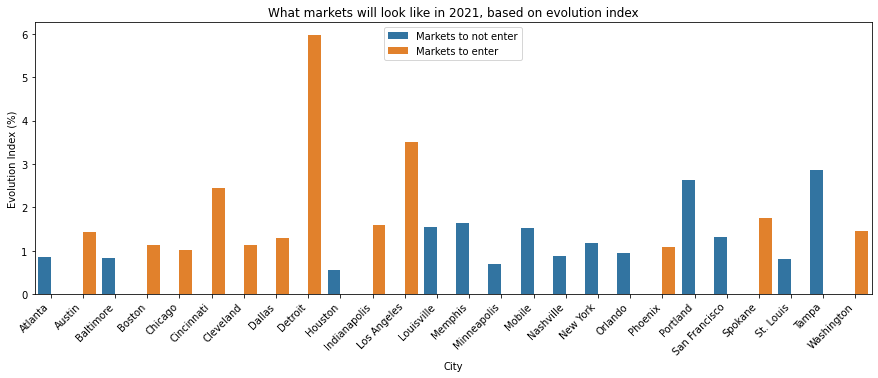

In [51]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()

# Notes for improvement:

* Calculate modeling by hand
* use oversampling to increase number of positive occurences.
* Look at the docs to stratify the data better in cross validation

-----

# Modeling Traditional

In [113]:
def split_data(df, train_size=.75,random_state = 124):
    train, test = train_test_split(df, train_size=train_size, random_state=random_state, stratify = df["should_enter"])
    train, validate = train_test_split(train, train_size=train_size, random_state=random_state, stratify = train["should_enter"])
    return train, validate, test

#__Main Pre-modeling function__#
def prep_data_for_modeling(df, features_for_modeling, label_feature):

    # To avoid Nan's, I have removed all data from 2006 (because all the var's would be nan)
    df_model = df[df.year > 2007]

    # Create an observation id to reduce the chance of mistake's
    df_model["observation_id"] = df_model.city + "_" + df_model.state + "_"  + df_model.year.astype(str)

    # select that features that we want to model, and use our observation id as the row id
    features_for_modeling += ["observation_id"]

    features_for_modeling += [label_feature]

    data = df_model[features_for_modeling].set_index("observation_id")
    
    train, validate, test = split_data(data)
    train = train.sort_values("observation_id")
    validate = validate.sort_values("observation_id")
    test = test.sort_values("observation_id")
    
    
    X_train = train.drop(columns=label_feature)
    y_train = train[label_feature]
    X_validate = validate.drop(columns=label_feature)
    y_validate = validate[label_feature]
    X_test = test.drop(columns=label_feature)
    y_test = test[label_feature]
    

    return X_train, X_validate, X_test, y_train, y_validate, y_test



def return_values(scaler, train, validate, test):
    '''
    Helper function used to updated the scaled arrays and transform them into usable dataframes
    '''
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return scaler, train_scaled, validate_scaled, test_scaled

# Linear scaler
def min_max_scaler(train,validate, test):
    '''
    Helper function that scales that data. Returns scaler, as well as the scaled dataframes
    '''
    scaler = MinMaxScaler().fit(train)
    scaler, train_scaled, validate_scaled, test_scaled = return_values(scaler, train, validate, test)
    return scaler, train_scaled, validate_scaled, test_scaled

In [254]:
df = preprocessing.get_model_df()
df = preprocessing.add_new_features(df)
df = filter_top_cities(df)
df = labeling_future_data(df)

In [255]:
df = df.append(df[df.should_enter])
df = df.append(df[df.should_enter])
df = df.append(df[df.should_enter])

In [256]:
# What percent of the data is positive?
(df.should_enter).mean()

0.3756906077348066

In [257]:
features_for_modeling = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]
label_feature = "should_enter"
X_train, X_validate, X_test, y_train, y_validate, y_test = prep_data_for_modeling(df, features_for_modeling, label_feature)

In [258]:
scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(X_train, X_validate, X_test)

In [259]:
train_scaled

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
Atlanta_GA_2008,0.023256,0.012324,0.006414,0.033455
Atlanta_GA_2009,0.186047,0.341549,0.115395,0.046596
Atlanta_GA_2009,0.186047,0.341549,0.115395,0.046596
Atlanta_GA_2010,0.232558,0.087637,0.017641,0.056728
Atlanta_GA_2011,0.209302,0.063380,0.020037,0.045856
...,...,...,...,...
Washington_DC_2014,0.186047,0.046587,0.117816,0.200601
Washington_DC_2016,0.162791,0.070423,0.033947,0.338726
Washington_DC_2018,0.139535,0.060739,0.035003,0.314513
Washington_DC_2019,0.093023,0.048290,0.010422,0.108962


# Decision Tree

In [260]:
predictions = pd.DataFrame({"actual": y_train, "baseline": y_train.mode()[0]})

In [261]:
for i in range(1, 20):
    clf, y_pred = model.run_clf(train_scaled, y_train, i)
    score = clf.score(train_scaled, y_train)
    validate_score = clf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.65. validate_score = 0.63, recall = 0.18
Max_depth = 2, accuracy_score = 0.66. validate_score = 0.63, recall = 0.18
Max_depth = 3, accuracy_score = 0.72. validate_score = 0.60, recall = 0.69
Max_depth = 4, accuracy_score = 0.74. validate_score = 0.64, recall = 0.44
Max_depth = 5, accuracy_score = 0.81. validate_score = 0.63, recall = 0.63
Max_depth = 6, accuracy_score = 0.85. validate_score = 0.67, recall = 0.71
Max_depth = 7, accuracy_score = 0.90. validate_score = 0.68, recall = 0.81
Max_depth = 8, accuracy_score = 0.93. validate_score = 0.68, recall = 0.83
Max_depth = 9, accuracy_score = 0.94. validate_score = 0.70, recall = 0.90
Max_depth = 10, accuracy_score = 0.96. validate_score = 0.78, recall = 0.94
Max_depth = 11, accuracy_score = 0.96. validate_score = 0.75, recall = 0.94
Max_depth = 12, accuracy_score = 0.98. validate_score = 0.82, recall = 1.00
Max_depth = 13, accuracy_score = 0.99. validate_score = 0.80, recall = 1.00
Max_depth = 14, accur

In [262]:
clf, y_pred = model.run_clf(train_scaled, y_train, 4)
predictions["decision_tree"] = y_pred

In [263]:
accuracy_score, matrix, report = model.accuracy_report(clf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.74
       False  True 
False    154      7
True      64     51


,False,True,accuracy,macro avg,weighted avg
precision,0.706422,0.879310,0.742754,0.792866,0.778459
recall,0.956522,0.443478,0.742754,0.700000,0.742754
f1-score,0.812665,0.589595,0.742754,0.701130,0.719719
support,161.000000,115.000000,0.742754,276.000000,276.000000


# Random Forest

In [264]:
for i in range(1, 20):
    rf, y_pred = model.run_rf(train_scaled, y_train, 1, i)
    score = rf.score(train_scaled, y_train)
    validate_score = rf.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 0.72. validate_score = 0.64, recall = 0.37
Max_depth = 2, accuracy_score = 0.73. validate_score = 0.64, recall = 0.39
Max_depth = 3, accuracy_score = 0.77. validate_score = 0.67, recall = 0.50
Max_depth = 4, accuracy_score = 0.86. validate_score = 0.71, recall = 0.69
Max_depth = 5, accuracy_score = 0.92. validate_score = 0.75, recall = 0.83
Max_depth = 6, accuracy_score = 0.97. validate_score = 0.79, recall = 0.93
Max_depth = 7, accuracy_score = 0.99. validate_score = 0.84, recall = 0.98
Max_depth = 8, accuracy_score = 0.99. validate_score = 0.84, recall = 0.98
Max_depth = 9, accuracy_score = 1.00. validate_score = 0.85, recall = 1.00
Max_depth = 10, accuracy_score = 1.00. validate_score = 0.84, recall = 1.00
Max_depth = 11, accuracy_score = 1.00. validate_score = 0.85, recall = 1.00
Max_depth = 12, accuracy_score = 1.00. validate_score = 0.85, recall = 1.00
Max_depth = 13, accuracy_score = 1.00. validate_score = 0.85, recall = 1.00
Max_depth = 14, accur

In [265]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 5)
predictions["random_forest"] = y_pred

In [266]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.92
       False  True 
False    159      2
True      20     95


,False,True,accuracy,macro avg,weighted avg
precision,0.888268,0.979381,0.92029,0.933825,0.926232
recall,0.987578,0.826087,0.92029,0.906832,0.920290
f1-score,0.935294,0.896226,0.92029,0.915760,0.919016
support,161.000000,115.000000,0.92029,276.000000,276.000000


# KNN

In [267]:
for i in range(1, 20):
    knn, y_pred = model.run_knn(train_scaled, y_train, i)
    score = knn.score(train_scaled, y_train)
    validate_score = knn.score(validate_scaled, y_validate)
    _, _, report = model.accuracy_report(clf, y_pred, y_train)
    recall_score = report["True"].recall
    print(f"Max_depth = {i}, accuracy_score = {score:.2f}. validate_score = {validate_score:.2f}, recall = {recall_score:.2f}")

Max_depth = 1, accuracy_score = 1.00. validate_score = 0.77, recall = 1.00
Max_depth = 2, accuracy_score = 0.98. validate_score = 0.72, recall = 0.95
Max_depth = 3, accuracy_score = 0.91. validate_score = 0.68, recall = 0.97
Max_depth = 4, accuracy_score = 0.87. validate_score = 0.63, recall = 0.78
Max_depth = 5, accuracy_score = 0.83. validate_score = 0.62, recall = 0.82
Max_depth = 6, accuracy_score = 0.75. validate_score = 0.59, recall = 0.54
Max_depth = 7, accuracy_score = 0.76. validate_score = 0.55, recall = 0.63
Max_depth = 8, accuracy_score = 0.76. validate_score = 0.64, recall = 0.52
Max_depth = 9, accuracy_score = 0.74. validate_score = 0.64, recall = 0.60
Max_depth = 10, accuracy_score = 0.75. validate_score = 0.64, recall = 0.56
Max_depth = 11, accuracy_score = 0.74. validate_score = 0.61, recall = 0.60
Max_depth = 12, accuracy_score = 0.74. validate_score = 0.65, recall = 0.52
Max_depth = 13, accuracy_score = 0.73. validate_score = 0.67, recall = 0.58
Max_depth = 14, accur

In [268]:
knn, y_pred = model.run_knn(train_scaled, y_train, 3)
predictions["knn"] = y_pred

In [269]:
accuracy_score, matrix, report = model.accuracy_report(knn, y_pred, y_train)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.91
       False  True 
False    138     23
True       3    112


,False,True,accuracy,macro avg,weighted avg
precision,0.978723,0.829630,0.905797,0.904177,0.916601
recall,0.857143,0.973913,0.905797,0.915528,0.905797
f1-score,0.913907,0.896000,0.905797,0.904954,0.906446
support,161.000000,115.000000,0.905797,276.000000,276.000000


In [270]:
# How do the different models compare on accuracy?
print("Accuracy Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report.accuracy[0]:.2f}')

Accuracy Scores
---------------
Actual = 1.00
Baseline = 0.58
Decision_Tree = 0.74
Random_Forest = 0.92
Knn = 0.91


In [271]:
# How do the different models compare on recall?
print("Recall Scores")
print("---------------")
for i in range(predictions.shape[1]):
    report = model.create_report(predictions.actual, predictions.iloc[:,i])
    print(f'{predictions.columns[i].title()} = {report["True"].loc["recall"]:.2f}')

Recall Scores
---------------
Actual = 1.00
Baseline = 0.00
Decision_Tree = 0.44
Random_Forest = 0.83
Knn = 0.97


# Evaluate

In [289]:
rf, y_pred = model.run_rf(train_scaled, y_train, 1, 5)

In [290]:
y_pred = rf.predict(test_scaled)

In [291]:
accuracy_score, matrix, report = model.accuracy_report(rf, y_pred, y_test)
print(accuracy_score)
print(matrix)
report

Accuracy on dataset: 0.78
       False  True 
False     66      6
True      21     30


,False,True,accuracy,macro avg,weighted avg
precision,0.758621,0.833333,0.780488,0.795977,0.789599
recall,0.916667,0.588235,0.780488,0.752451,0.780488
f1-score,0.830189,0.689655,0.780488,0.759922,0.771919
support,72.000000,51.000000,0.780488,123.000000,123.000000


----

# Prediction

In [275]:
df = preprocessing.get_model_df()
df = preprocessing.add_new_features(df)
df = filter_top_cities(df)

In [276]:
df.head()

,city,state,year,quantity_of_mortgages_pop,total_mortgage_volume_pop,average_mortgage_volume_pop,median_mortgage_amount_pop,quantity_of_mortgages_nc,total_mortgage_volume_nc,average_mortgage_volume_nc,median_mortgage_amount_nc,label,city_state_vol_delta_pop,city_state_vol_delta_nc,city_state_qty_delta_pop,city_state_qty_delta_nc,market_volume,market_volume_delta,ei,city_state
1474,Atlanta,GA,2006,6,33186800,5.531133e+06,4457100.0,2.0,9181100.0,4590550.0,4590550.0,False,NaN,NaN,NaN,NaN,6774129256,NaN,NaN,Atlanta_GA
1850,Atlanta,GA,2007,8,28277600,3.534700e+06,3031150.0,2.0,4541700.0,2270850.0,2270850.0,False,-0.147926,-0.505321,0.333333,0.0,4973263164,-0.265845,1.160618,Atlanta_GA
7566,Atlanta,GA,2008,2,6735000,3.367500e+06,3367500.0,1.0,4950000.0,4950000.0,4950000.0,False,-0.761826,0.089900,-0.750000,-0.5,4444102426,-0.106401,0.266534,Atlanta_GA
752,Atlanta,GA,2009,9,49972900,5.552544e+06,4400000.0,1.0,3750000.0,3750000.0,3750000.0,False,6.419881,-0.242424,3.500000,0.0,7882704846,0.773745,4.183172,Atlanta_GA
449,Atlanta,GA,2010,11,68788385,6.253490e+06,5196100.0,2.0,7203500.0,3601750.0,3601750.0,False,0.376514,0.920933,0.222222,1.0,16193901958,1.054359,0.670046,Atlanta_GA


In [277]:
features_for_predicting = ["quantity_of_mortgages_pop", "city_state_qty_delta_pop", "ei", "median_mortgage_amount_pop"]

In [278]:
predictions = df[(df.year == 2020) | (df.year == 2019)].groupby("city_state")[features_for_predicting].mean()
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop
city_state,,,,
Atlanta_GA,2.5,-0.208333,0.818544,14743525.0
Austin_TX,4.0,-0.250000,1.936679,27422850.0
Baltimore_MD,6.5,-0.420833,0.966084,12466625.0
Boston_MA,12.5,-0.023810,1.126264,11158750.0
Chicago_IL,11.0,-0.311741,0.981413,12010100.0
Cincinnati_OH,5.5,0.633333,2.959727,8620350.0
Cleveland_OH,2.0,0.571429,1.566514,9025000.0
Dallas_TX,4.0,-0.166667,1.303434,30065025.0
Detroit_MI,2.0,0.583333,8.755146,19445600.0


In [279]:
# Helper function used to updated the scaled arrays and transform them into usable dataframes
def return_values_prediction(scaler, df):
    train_scaled = pd.DataFrame(scaler.transform(df), columns=df.columns.values).set_index([df.index.values])
    return scaler, train_scaled

# Linear scaler
def min_max_scaler_prediction(df):
    scaler = MinMaxScaler().fit(df)
    scaler, df_scaled = return_values_prediction(scaler, df)
    return scaler, df_scaled

In [280]:
scaler, predictions_scaled = min_max_scaler_prediction(predictions)

In [281]:
predictions["label"] = clf.predict(predictions_scaled)

In [282]:
predictions

,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label
city_state,,,,,
Atlanta_GA,2.5,-0.208333,0.818544,14743525.0,False
Austin_TX,4.0,-0.250000,1.936679,27422850.0,False
Baltimore_MD,6.5,-0.420833,0.966084,12466625.0,False
Boston_MA,12.5,-0.023810,1.126264,11158750.0,True
Chicago_IL,11.0,-0.311741,0.981413,12010100.0,False
Cincinnati_OH,5.5,0.633333,2.959727,8620350.0,False
Cleveland_OH,2.0,0.571429,1.566514,9025000.0,False
Dallas_TX,4.0,-0.166667,1.303434,30065025.0,False
Detroit_MI,2.0,0.583333,8.755146,19445600.0,True


In [283]:
city = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[0]

state = predictions.reset_index().city_state.str.split("_", n=1, expand=True)[1]

In [284]:
predictions = predictions.reset_index()

In [285]:
predictions["city"] = city

predictions["state"] = state

In [286]:
predictions

,city_state,quantity_of_mortgages_pop,city_state_qty_delta_pop,ei,median_mortgage_amount_pop,label,city,state
0,Atlanta_GA,2.5,-0.208333,0.818544,14743525.0,False,Atlanta,GA
1,Austin_TX,4.0,-0.250000,1.936679,27422850.0,False,Austin,TX
2,Baltimore_MD,6.5,-0.420833,0.966084,12466625.0,False,Baltimore,MD
3,Boston_MA,12.5,-0.023810,1.126264,11158750.0,True,Boston,MA
4,Chicago_IL,11.0,-0.311741,0.981413,12010100.0,False,Chicago,IL
5,Cincinnati_OH,5.5,0.633333,2.959727,8620350.0,False,Cincinnati,OH
6,Cleveland_OH,2.0,0.571429,1.566514,9025000.0,False,Cleveland,OH
7,Dallas_TX,4.0,-0.166667,1.303434,30065025.0,False,Dallas,TX
8,Detroit_MI,2.0,0.583333,8.755146,19445600.0,True,Detroit,MI
9,Houston_TX,5.0,-0.511364,0.522507,13573625.0,False,Houston,TX


In [287]:
predictions.to_csv("predictions.csv")

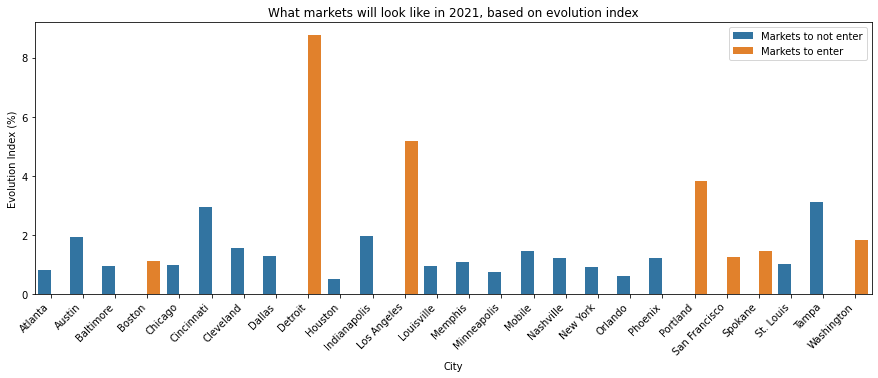

In [288]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=predictions, x="city", y="ei", hue="label")
plt.title("What markets will look like in 2021, based on evolution index")
plt.xticks(rotation=45, ha="right")
plt.xlabel("City")
plt.ylabel("Evolution Index (%)")
new_labels = ['Markets to not enter', 'Markets to enter']
h, l = ax.get_legend_handles_labels()
ax.legend(h, new_labels)
plt.show()